 <div>
 <h1><center>Applications de l'Informatique Quantique</h1>
<h2><center>Projet Noté : OPTIMISATION </h2>
<h3> Professeur: Durantin Gautier</h3>
<h4> Étudiants: Bonnet Roman, Pages Hugo </h4>
</div>
    
    

### Objectifs du notebook
    
L’établissement du don du sang se demande quels sont les critères (parmi les 4 proposés) qui 
prédisent le mieux la tendance à donner son sang ou non, afin de mettre en place des règles métier 
pour recontacter certains anciens donneurs. On cherche à éviter d’utiliser des features deux à deux 
redondantes.
    
### Imports
    
Le notebook, s'appuie sur deux librairies principales :
- *qiskit* : pour la définition des circuits quantiques et leur préparation pour l'exécution
- *qiskit_aer* : pour la simulation du comportement des ordinateurs quantiques. Le module nous permettra d'exécuter nos circuits en pratique

In [22]:
from qiskit.circuit import QuantumCircuit
from qiskit_aer.primitives import SamplerV2 as Sampler, EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit.circuit.library import QAOAAnsatz

from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error


from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Visualisation des données
## 1.1 Histogramme
On commence par représenter les données afin de mieux visualiser les differentes catégories. Afin d'observer les données nous affichons 4 histogrammes. 
- Haut gauche : 10 plus gros donneurs par frequences, classé du plus fréquent vers le moins fréquent.  
- Haut droite : 20 donneurs ayant donné le plus récemments , classé du plus récent vers le moins récent.
- Bas gauche  : 10 plus gros donneurs par quantité total de sang donné, classé du plus vers le moins.
- Bas droite  : 20 donneurs ayant donné leur sang pour la première fois depuis le plus longtemps.

remarque : les différentes catégories ayant de valeurs numeriques bien différentes nous utilisons une échelle logarithmique. 

In [23]:
# 1. Chargement et préparation
data = pd.read_csv("transfusion.csv")
data.columns = [c.strip() for c in data.columns] # Nettoyage des noms
data['id Number'] = range(1, len(data) + 1)

# Liste des colonnes numériques pour lesquelles on veut le "Top 10"
name_categories = [
    'Frequency (times)', 
    'Recency (months)', 
    'Monetary (c.c. blood)', 
    'Time (months)'
]



## 1.2 Charactéristiques en fonction des donneurs 

In [24]:
Freq=data['Frequency (times)'].to_numpy()
Rec=data['Recency (months)'].to_numpy()
Monet=data['Monetary (c.c. blood)'].to_numpy()
Time=data['Time (months)'].to_numpy()

Result=(data['whether he/she donated blood in March 2007']).to_numpy()
All_categories = [Freq, Rec, Monet, Time]

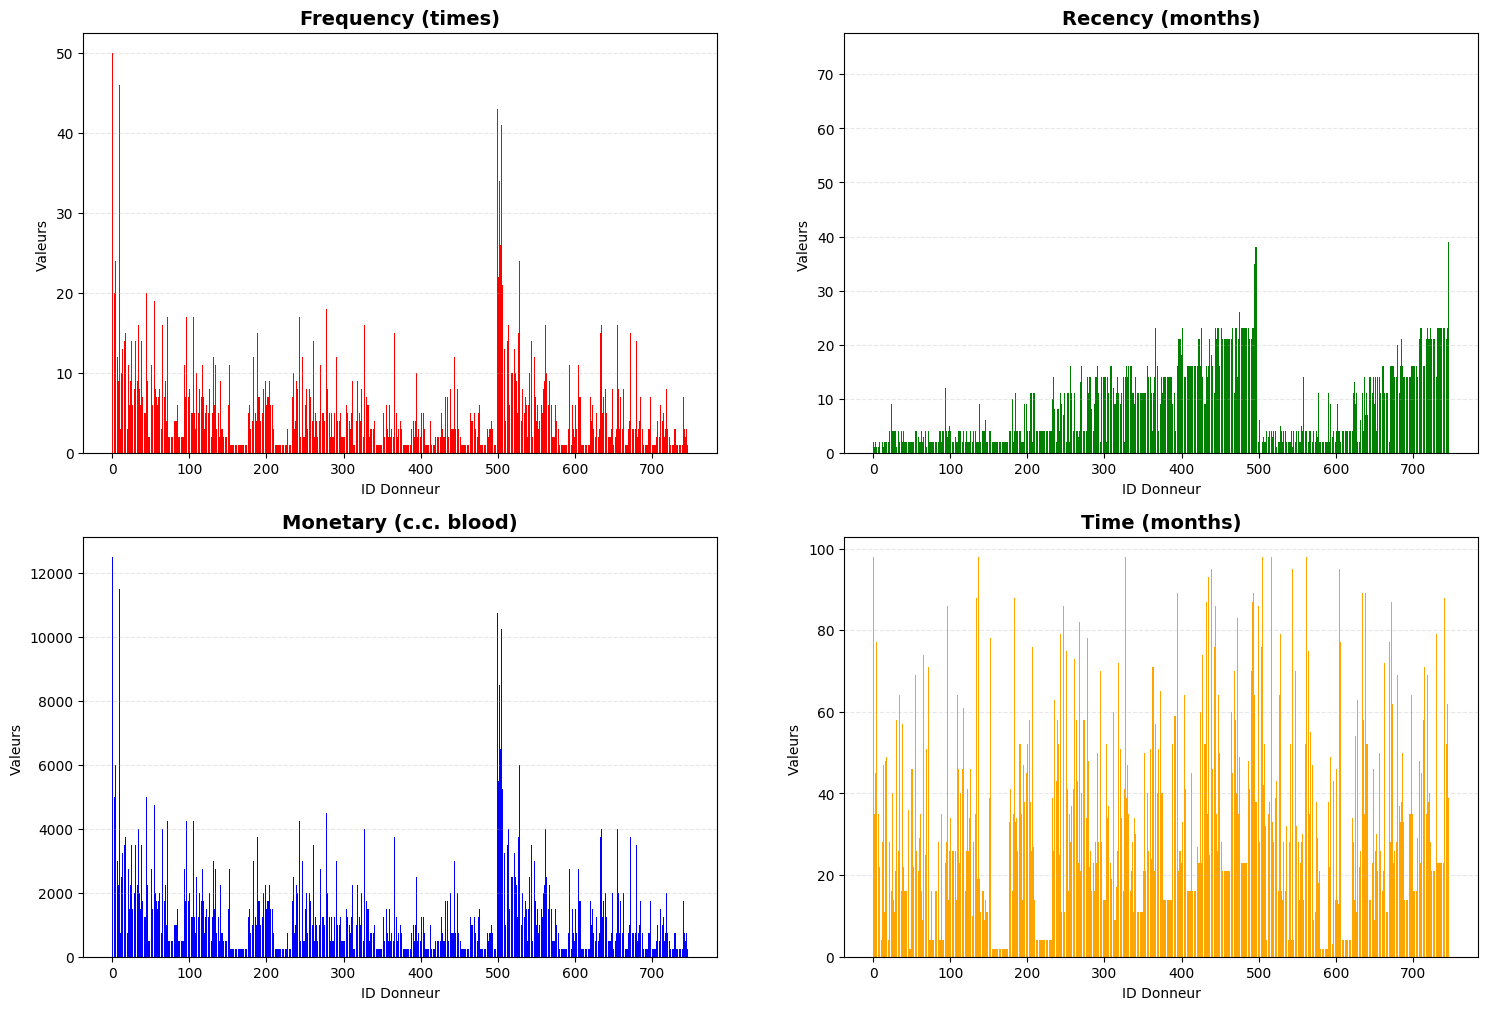

In [25]:
#Chargement de toutes les colonnes


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
axes = axes.flatten()
colors=['red', 'green', 'blue', 'orange']
for i, cat in enumerate(All_categories): 
    axes[i].bar(range(len(cat)), cat, label=name_categories[i], color=colors[i])
    axes[i].set_title(f"{name_categories[i]}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("ID Donneur")
    axes[i].set_ylabel("Valeurs ") # Echelle log pour comparer Monetary aux autres
    axes[i].grid(axis='y', linestyle='--', alpha=0.3)



# 2. Formulation du problème d'optimisation sous forme QUBO (Quadratic unconstrained binary optimization): 

Notre objectif est de trouver le set de catégories parmis les suivantes: 
-  Frequency : le nombre total de dons effectués par le donneur 
-  Recency : le nombre de mois écoulés depuis le dernier don du sang. 
-  Monetary : le volume total (en centimètres cubes) de sang donné 
-  Time : le nombre de mois écoulés depuis le premier don du sang

permettant de prevoir si au passage du camion en mars 2007 les donneurs ont donnés oui ou non leurs sang. On souhaite éliminer les informations deux à deux redondante. 

Afin d'appliquer le QAOA qui nécessitera un Hamiltonien, on cherche à se ramener à une forme QUBO de formulation du problème d'optimisation. Pour rappel, les problèmes QUBO sont formulés avec la fonction de cout suivante :

$$ C(X) = X^T Q X + c^T X $$

## 2.1. Construction de $X$ :  


Si on doit choisir parmi $n$ Categories, on note $X=[x_0,x_1,..,x_{n-1}]$ le vecteur décrivant si la catégories est prise en compte ou non. Les $x_i$ valent tous $0$ ou $1$, et représentent si la categorie est choisi ou pas.

Exemple : $X=[1,0,0,1]$ veut dire je prend en compte le frequence de don et le nombre de mois écoulés depuis le premier don du sang afin de savoir si un donneur va donner ou pas. 



## 2.2. Fonction à optimiser : 

Il est indiqué dans l'énoncé que nous souhaitons les caractèristiques qui prèdisent le mieux le don du sang en mars 2007 et éviter la redondance. Nous appelons $Y=[y_0,y_1,..,y_{n-1}]$ le vecteur binaire qui nous dis si oui ou non le donneur $i$ à donné son sang lors du passage du camion. 
Nous souhaitons donc maximiser la corrélation (ou l'information mutuelle) entre chaque categorie $i$ et la cible $Y$ tout en minimisant la redondance. 
La fonction d'optimisation peut donc s'écrire comme $$H(x) = \underbrace{-\sum_{i} p_i x_i}_{\text{Pertinence}} + \underbrace{\sum_{i < j} r_{ij} x_i x_j}_{\text{Redondance}} + \underbrace{C \left( \sum_{i} x_i - k \right)^2}_{\text{Contrainte}}$$

En ajoutant la Contrainte on peut forcer le système à choisir exactement $k$ critères ($k \in \{1, 2, 3\}$).

Remarque : L'ajout de la contrainte dans le fonction d'optimisation ne fait pas sortir le problème de la classe "Unconstrainged" nécéssaire à l'élaboration d'un problème QUBO. Dans le cadre d'un QUBO, la fonction doit rester quadratique (de degré 2 maximum) ce qui est bien le cas dans notre definition. \\
Si la contrainte est respectée, le terme vaut 0 (pas de coût supplémentaire).

Si la contrainte n'est pas respectée (ex: on choisit 4 critères au lieu de 2), le terme devient positif et très grand, ce qui "pénalise" cette solution.


## 2.3  Incorporation de la contrainte de cardinalité

La contrainte est $\sum x_i = k$, ce qui donne la pénalité $C (\sum x_i - k)^2$. En utilisant le fait que $(\sum x_i) = \mathbf{1}^T X$, on développe :$$C (\mathbf{1}^T X - k)^2 = C (X^T \mathbf{1} \mathbf{1}^T X - 2k \mathbf{1}^T X + k^2)$$ Puisque $x_i^2 = x_i$, nous pouvons séparer le terme quadratique $X^T \mathbf{1} \mathbf{1}^T X$ en une partie strictement diagonale (linéaire) et une partie extra-diagonale (quadratique) : Termes $x_i^2$ (diagonale) $\rightarrow$ deviennent $\sum x_i$. Termes $x_i x_j$ (extra-diagonaux) $\rightarrow$ $\sum_{i \neq j} x_i x_j$. 

Formulation Finale : $C(X) = X^T R X + P^T X$ En regroupant la pertinence (négative car on veut la maximiser), la redondance et la contrainte, nous obtenons les nouveaux opérateurs $R$ et $P$ :La Matrice de Couplage $R$ (Quadratique). Elle gère la redondance et le fait de ne pas dépasser $k$ éléments. Pour $i \neq j$ :$$R_{ij} = \frac{1}{2}r_{ij} + C$$(On divise $r$ par 2 si la matrice est symétrique pour ne pas compter la redondance deux fois dans le produit matriciel).Le Vecteur de Biais $\mathcal{P}$ (Linéaire)Il gère la pertinence et la direction vers le nombre $k$. Pour chaque $i$ :$$P_i = -w_i + C(1 - 2k)$$

In [26]:
import numpy as np

def build_R_P(features_list, target, k, A=1.0, B=1.0, C=1.0):
    """
    Calcule les paramètres P et R pour un nombre arbitraire de caractéristiques.
    
    Arguments:
    features_list : Liste d'arrays (ex: [recency, frequency, monetary, time, ...])
    target        : Array de la variable cible (0 ou 1)
    k             : Nombre de critères à sélectionner
    C             : Facteur de pénalité (Constraint weight)
    """
    X = np.array(features_list)
    n = X.shape[0]

    full_matrix = np.corrcoef(np.vstack([X, target]))

    p = np.abs(full_matrix[:-1, -1])
   
    r = full_matrix[:-1, :-1]
    np.fill_diagonal(r, 0) 

    P = -(-A * p+ C * (1 - 2 * k))

    off_diag_mask = np.ones((n, n)) - np.eye(n)
    R = (0.5 * B * r+ C) * off_diag_mask
    
    return R, P


R,P=build_R_P(All_categories, Result, k=1, A=0.5, B=0.8, C=1.0)

   

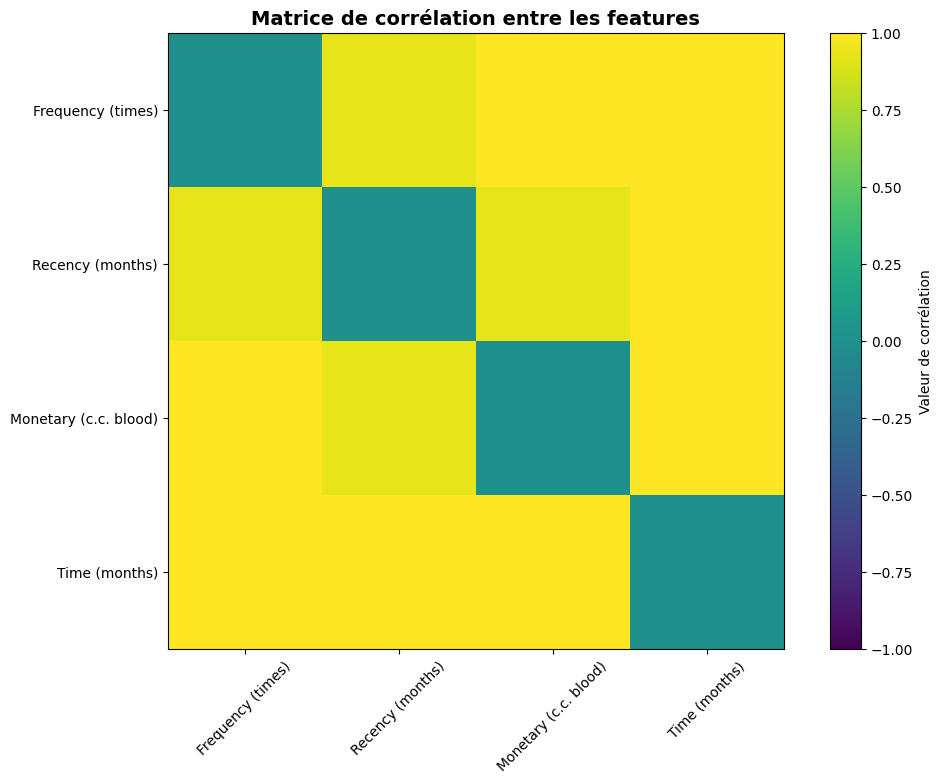

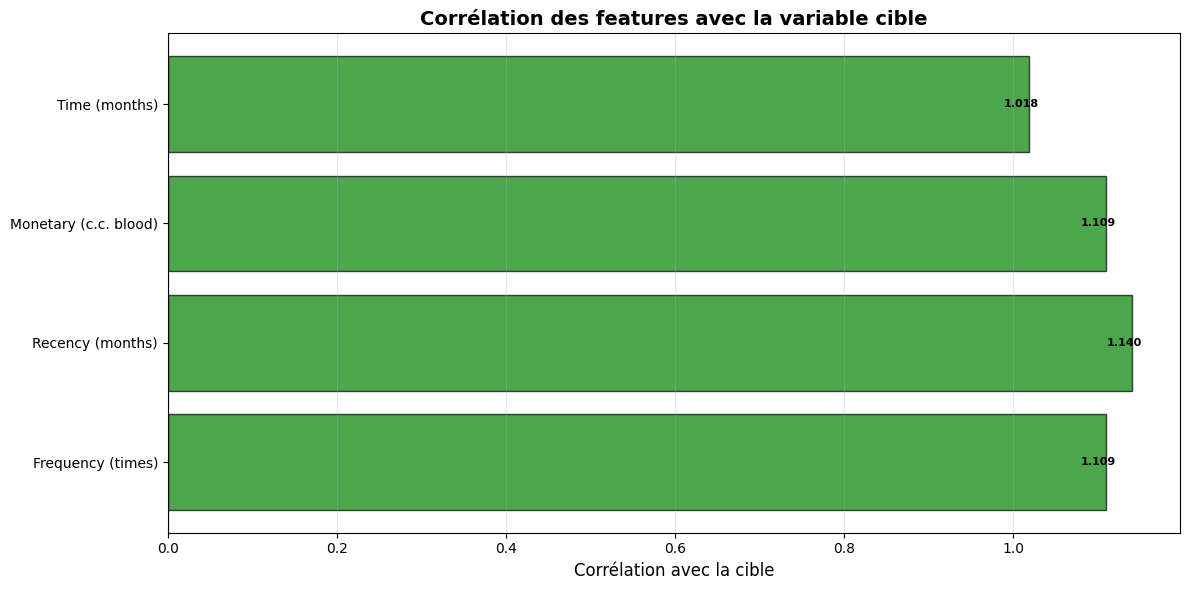

In [27]:
 
plt.figure(figsize=(12, 8))
plt.imshow(R, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(label='Valeur de corrélation') 
plt.xticks(ticks=np.arange(len(name_categories)), labels=name_categories, rotation=45, fontsize=10)
plt.yticks(ticks=np.arange(len(name_categories)), labels=name_categories, fontsize=10)
plt.title('Matrice de corrélation entre les features', fontsize=14, fontweight='bold')
plt.grid(False)
    
plt.figure(figsize=(12, 6))
colors = ['red' if x < 0 else 'green' for x in P]
bars = plt.barh(name_categories, P, color=colors, alpha=0.7, edgecolor='black')

# Ajouter les valeurs sur les barres
for idx, (bar, val) in enumerate(zip(bars, P)):
    plt.text(val - 0.03 if val > 0 else val + 0.03, idx, 
                 f'{val:.3f}', va='center', ha='left' if val > 0 else 'right',
                 fontweight='bold',
                 fontsize=8)

plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.xlabel('Corrélation avec la cible', fontsize=12)
plt.title('Corrélation des features avec la variable cible', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()



## 2.4 Conclusion 
Nous avons desormais tout les paramètres pour formuler le problème sous la forme QUBO $$ C(X) = X^T R X - P^T X $$  (avec $R$ Le terme quadratique contenant la pénalité pour la redondance ($r_{ij}$) et la pénalité pour ne pas dépasser $k$ et $P$ Le terme linéaire contenant la pertinence et une partie de la contrainte de cardinalité  ). 


# 3. Brut force

In [28]:


def get_criterion(x: np.ndarray, R: np.ndarray,P : np.ndarray):
   return np.dot(x.T, np.dot(R, x)) - np.dot(P, x)



In [29]:
import itertools


combinations = list(itertools.product(*[[0,1]]*4))

values = []
for combination in combinations:
  values.append((combination, get_criterion(np.array(combination),R, P)))
  print(combination, values[-1][1])
best= [comb for comb, val in values if val==min(val for _,val in values)]
print("Meilleur portefeuille(s) :", best)
print("ce qui correspond à sélectionner les caractéristiques suivantes :")
for i, feature in enumerate(name_categories):
    if best[0][i] == 1:
        print(f"- {feature}")

(0, 0, 0, 0) 0.0
(0, 0, 0, 1) -1.017927204022129
(0, 0, 1, 0) -1.1093167209048653
(0, 0, 1, 1) 0.38070829133134865
(0, 1, 0, 0) -1.1399344337175192
(0, 1, 0, 1) -0.029367162399500213
(0, 1, 1, 0) -0.3954475290880155
(0, 1, 1, 1) 3.2230719584883474
(1, 0, 0, 0) -1.1093167209048658
(1, 0, 0, 1) 0.38070829133134865
(1, 0, 1, 0) 0.5813665581902683
(1, 0, 1, 1) 4.579343786684826
(1, 1, 0, 0) -0.3954475290880166
(1, 1, 0, 1) 3.2230719584883456
(1, 1, 1, 0) 3.149039375541487
(1, 1, 1, 1) 9.27551107937619
Meilleur portefeuille(s) : [(0, 1, 0, 0)]
ce qui correspond à sélectionner les caractéristiques suivantes :
- Recency (months)


## 4. Derivation du Hamiltonien

In [30]:
def get_operator(sigma: np.ndarray, mu : np.ndarray):
    num_nodes = len(mu)
    pauli_list = [] #contient la liste des matrices de Pauli à utiliser
    coeffs = [] #contient les coefficients associées à chaque matrice de Pauli

    #Termes en ZiZj
    for i in range(num_nodes):
        for j in range(i):
            if sigma[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(sigma[i,j]/4)

    #Termes en Zi
    for i in range(num_nodes):
            x_p = np.zeros(num_nodes, dtype=bool)
            z_p = np.zeros(num_nodes, dtype=bool)
            z_p[i] = True
            pauli_list.append(Pauli((z_p, x_p)))
            coeffs.append(+mu[i]/2-np.sum(sigma[i])/2)

    #shift = termes constants
    shift=np.sum(sigma)/4-np.sum(mu)/2
    pauli_list.append('IIII')
    coeffs.append(shift)

    return SparsePauliOp(pauli_list, coeffs=coeffs)

problem_operator = get_operator(R, P)

## 5. QAOA

In [31]:
#paramètres initiaux arbitraires

def get_optimal_qaoa_circuit(r, problem_operator,initial_gamma=np.pi, initial_beta=np.pi/2):
    init_params = [initial_gamma, initial_beta]*r
    circuit=QAOAAnsatz(cost_operator=problem_operator, reps=r)
    
    def cost_func_estimator(params, ansatz, hamiltonian, estimator):
        #Cette fonction estime le coût pour chaque configuration des paramètres, via le calcul de l'espérance mathématique du Hamiltonien.
        pass_manager = generate_preset_pass_manager(1, AerSimulator())
        isa_qc=pass_manager.run(ansatz.assign_parameters(params))
        pub = (isa_qc, hamiltonian)
        job = estimator.run([pub])
        results = job.result()[0]
        cost = results.data.evs
        cost_vals.append(cost)
        return cost
    
    cost_vals=[]
    
    estimator = Estimator()
    estimator.options.default_shots = 1000
    result = minimize(
            cost_func_estimator,
            init_params,
            args=(circuit, problem_operator, estimator),
            method="COBYLA",
            tol=1e-1,
    )
    
    #Definition du circuit optimal pour le QAOA
    optimal_parameters = result.x
    optimal_qaoa_circuit=circuit.assign_parameters(optimal_parameters)
    optimal_qaoa_circuit.measure_all()
    
    
    
    
    
    return optimal_qaoa_circuit, cost_vals

optimal_qaoa_circuit, cost_vals = get_optimal_qaoa_circuit(r=2, problem_operator=problem_operator)

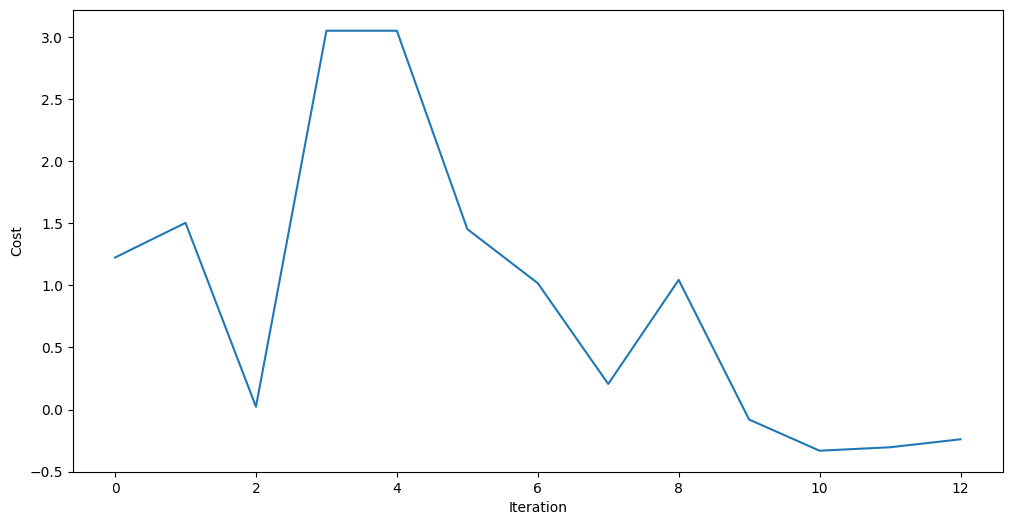

In [32]:

plt.figure(figsize=(12, 6))
plt.plot(cost_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [33]:
def run_qaoa_circuit(circuit, depolarizing_error_prob=0):
    #génération d'un pass manager adapté à la machine (ici AerSimulator) et avec un niveau d'optimisation de 1
    pass_manager = generate_preset_pass_manager(1, AerSimulator())
    
    if depolarizing_error_prob > 0:
        noise_model = NoiseModel()
        prob_depolarisation = 0.02
        noise_model.add_all_qubit_quantum_error(
            depolarizing_error(prob_depolarisation, num_qubits=2), ["cx"]
        )
        sampler=Sampler(options=dict(backend_options=dict(noise_model=noise_model)))
    else : 
        sampler=Sampler()
    isa_optimal_qaoa_circuit=pass_manager.run(optimal_qaoa_circuit)
    job=sampler.run([isa_optimal_qaoa_circuit],shots=10000)
    result=job.result()

    counts=result[0].data.meas.get_counts()
    
    return counts



## 7. Fake backend 

In [34]:
import pickle
from qiskit_aer.noise import NoiseModel
def fake_backend(isa_optimal_qaoa_circuit):
    with open('ibm_brisbane_eagle.mdl','rb') as f:
        real_noise_dict = pickle.load(f)

    realistic_noise_model = NoiseModel.from_dict(real_noise_dict)


    #on execute la même expérience sur ce modele
    realistic_sampler = Sampler(options=dict(backend_options=dict(noise_model=realistic_noise_model)))
    job=realistic_sampler.run([isa_optimal_qaoa_circuit],shots=1024)
    result=job.result()
    return result[0].data.meas.get_counts()


# Resuts for k =1, k=2, k=3

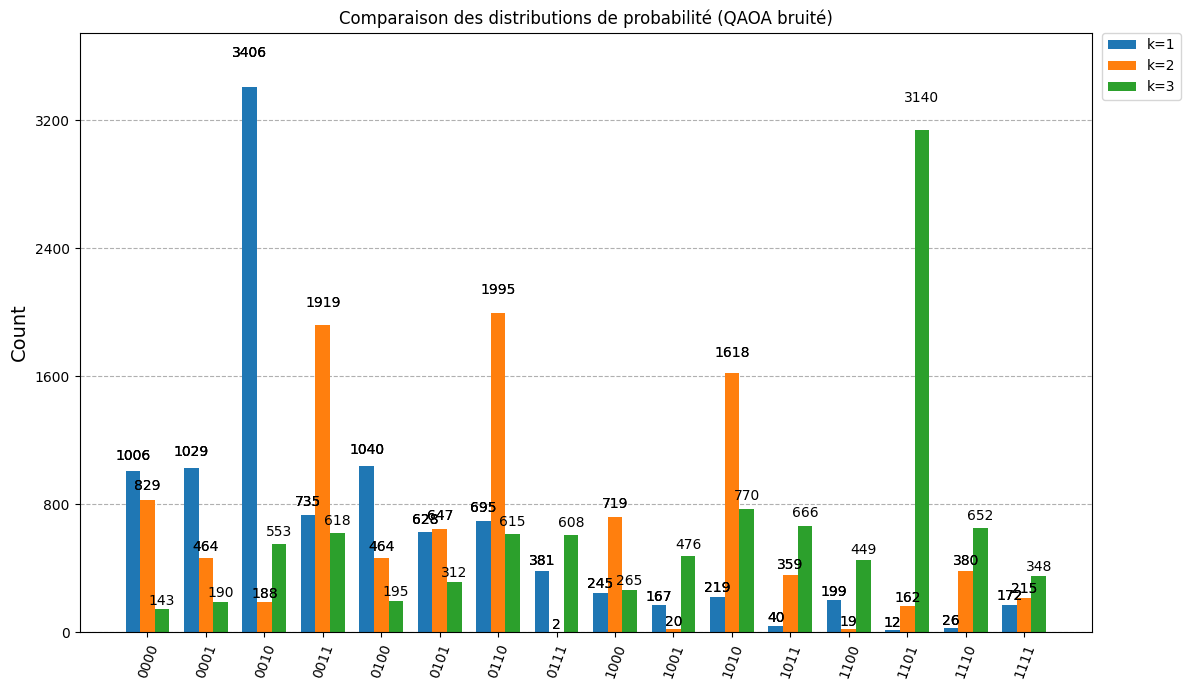

In [55]:
res=[]

for k in [1, 2, 3]:
    R, P = build_R_P(All_categories, Result, k=k, A=0.5, B=0.8, C=1.5)
    problem_operator = get_operator(R, P)
    optimal_qaoa_circuit, cost_vals = get_optimal_qaoa_circuit(r=3, problem_operator=problem_operator)
    counts=run_qaoa_circuit(optimal_qaoa_circuit, depolarizing_error_prob=0.2)
    res.append(counts)

plot_histogram(res, 
               legend=[f"k={k}" for k in [1, 2, 3]],
               title="Comparaison des distributions de probabilité (QAOA bruité)",
               figsize=(12, 7))

/tmp/ipykernel_11105/2235785535.py:9: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.15.0 and will be removed no earlier than 3 months from that release date.
  realistic_noise_model = NoiseModel.from_dict(real_noise_dict)
/tmp/ipykernel_11105/2235785535.py:9: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.15.0 and will be removed no earlier than 3 months from that release date.
  realistic_noise_model = NoiseModel.from_dict(real_noise_dict)
/tmp/ipykernel_11105/2235785535.py:9: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.15.0 and will be removed no earlier than 3 months from that release date.
  realistic_noise_model = NoiseModel.from_dict(real_noise_dict)


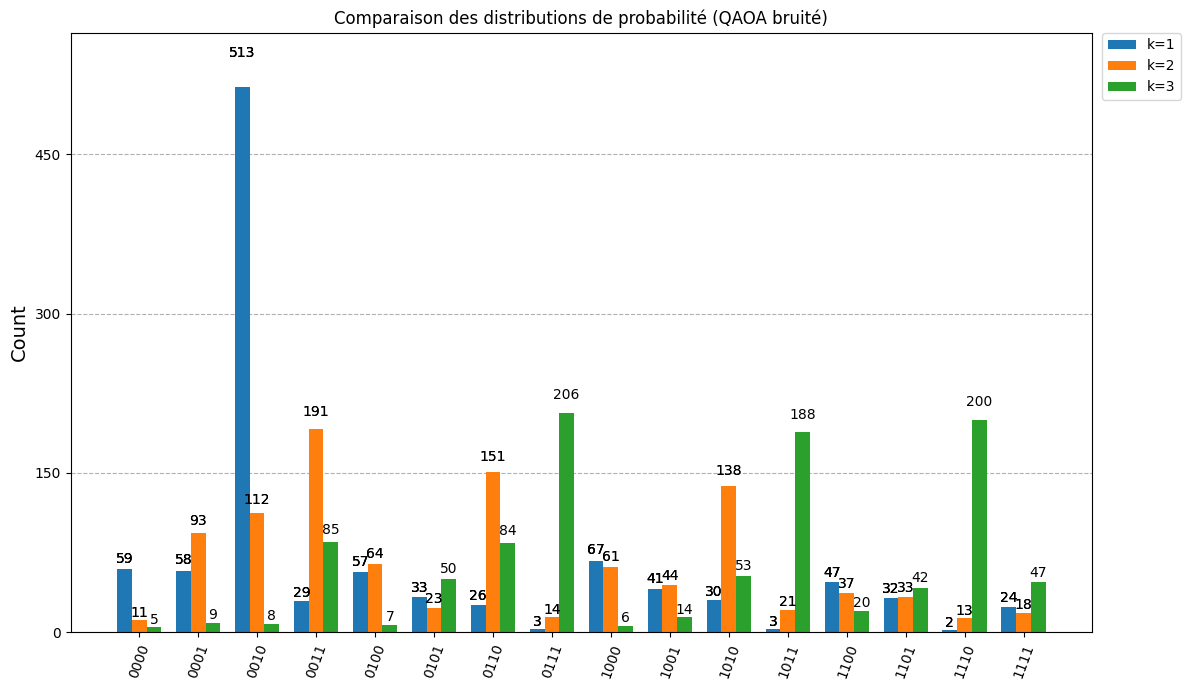

In [56]:
import pickle
from qiskit_aer.noise import NoiseModel
def fake_backend(qaoa_circuit):
    
    pass_manager = generate_preset_pass_manager(1, AerSimulator())
    with open('ibm_brisbane_eagle.mdl','rb') as f:
        real_noise_dict = pickle.load(f)

    realistic_noise_model = NoiseModel.from_dict(real_noise_dict)

    isa_qaoa_circuit=pass_manager.run(qaoa_circuit)
    #on execute la même expérience sur ce modele
    realistic_sampler = Sampler(options=dict(backend_options=dict(noise_model=realistic_noise_model)))
    job=realistic_sampler.run([isa_qaoa_circuit],shots=1024)
    result=job.result()
    return result[0].data.meas.get_counts()

res=[]
for k in [1, 2, 3]:
    R, P = build_R_P(All_categories, Result, k=k, C=0.5)
    problem_operator = get_operator(R, P)
    optimal_qaoa_circuit, cost_vals = get_optimal_qaoa_circuit(r=3, problem_operator=problem_operator)

    counts=fake_backend(optimal_qaoa_circuit)
    res.append(counts)
    
plot_histogram(res, 
               legend=[f"k={k}" for k in [1, 2, 3]],
               title="Comparaison des distributions de probabilité (QAOA bruité)",
               figsize=(12, 7))

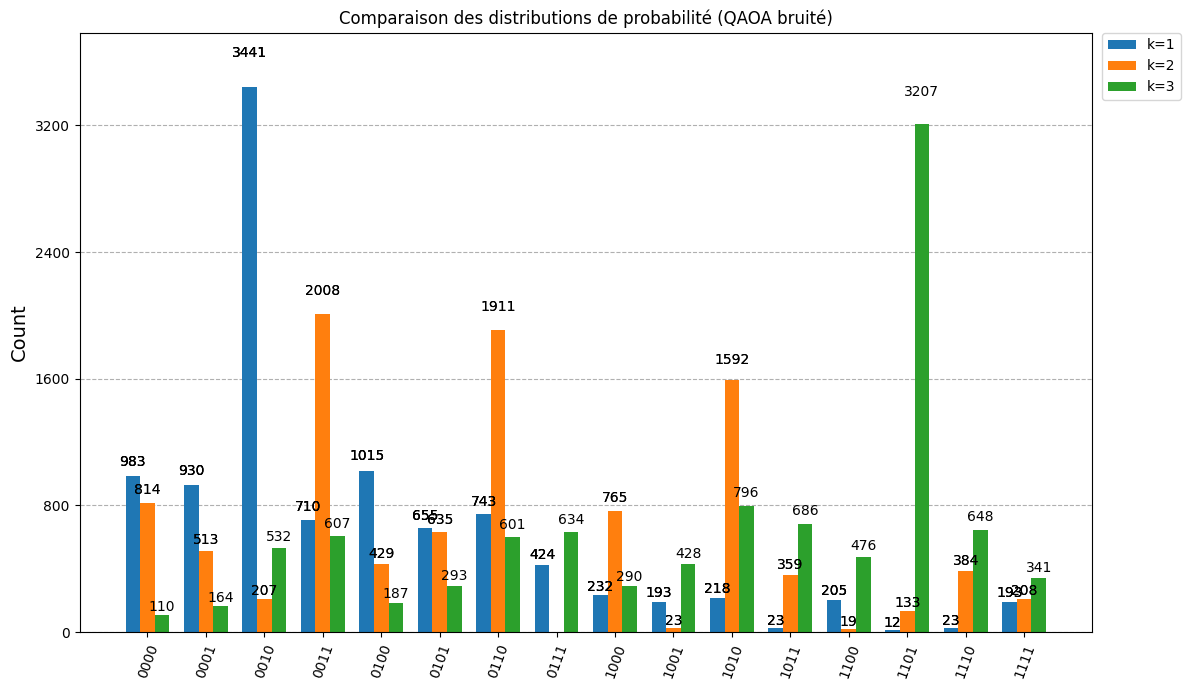

In [60]:
res_nb=[]
res_b=[]

for k in [1, 2, 3]:
    R, P = build_R_P(All_categories, Result, k=k, A=0.5, B=0.8, C=1.5)
    problem_operator = get_operator(R, P)
    optimal_qaoa_circuit, cost_vals = get_optimal_qaoa_circuit(r=3, problem_operator=problem_operator)
    counts=run_qaoa_circuit(optimal_qaoa_circuit, depolarizing_error_prob=0.2)
    res_b.append(counts)
    counts = run_qaoa_circuit(optimal_qaoa_circuit, depolarizing_error_prob=0.0)
    res_nb.append(counts)

plot_histogram(res_b, 
               legend=[f"k={k}" for k in [1, 2, 3]],
               title="Comparaison des distributions de probabilité (QAOA bruité)",
               figsize=(12, 7))


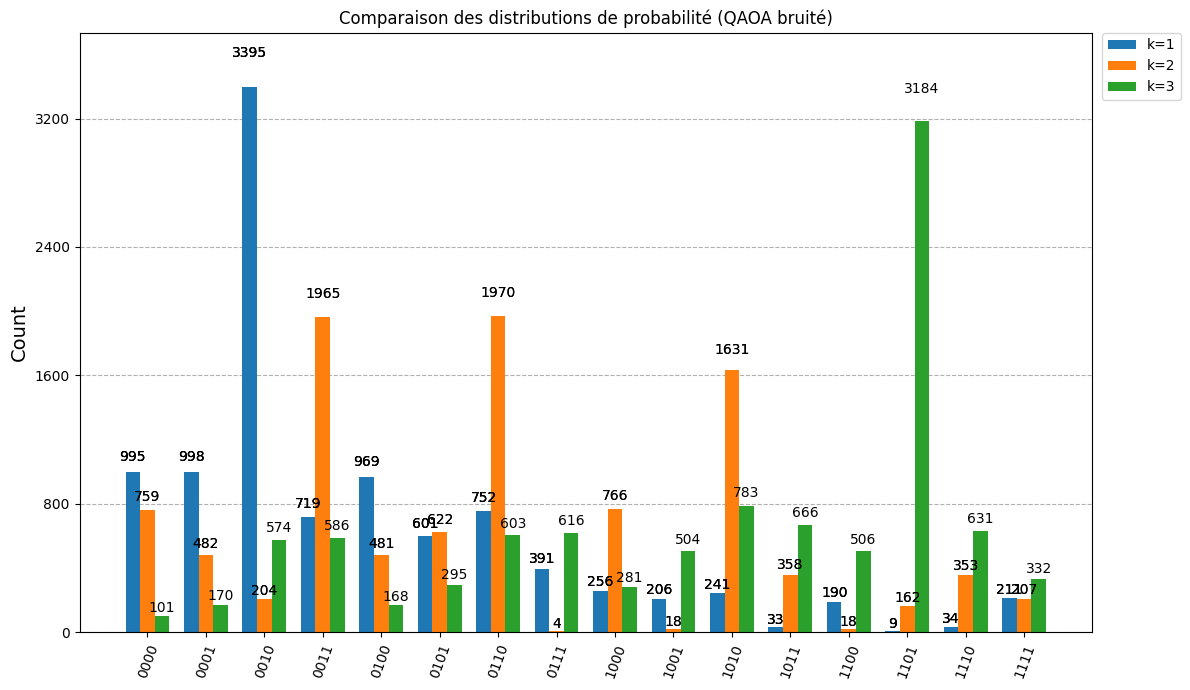

In [61]:
plot_histogram(res_nb, 
               legend=[f"k={k}" for k in [1, 2, 3]],
               title="Comparaison des distributions de probabilité (QAOA bruité)",
               figsize=(12, 7))